In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Device dignostics code

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Importing dataset

In [3]:
df = pd.read_csv(r"E:\Pytorch Datasets\Classification\wine+quality\winequality-white.csv", delimiter=';')

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Filtering Data

In [5]:
X = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:, -1] - 3)

In [6]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

Converting numpy to tensor

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [8]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [9]:
torch.unique(y)

tensor([0., 1., 2., 3., 4., 5., 6.])

In [12]:
y[1]

tensor(3.)

In [13]:
X.shape, y.shape

(torch.Size([4898, 11]), torch.Size([4898]))

Spliting training and testing data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3918, 11]),
 torch.Size([980, 11]),
 torch.Size([3918]),
 torch.Size([980]))

In [16]:
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

Build a Linear model by inheriting nn.Module

In [17]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=11, out_features=32)
        self.layer2 = nn.Linear(in_features=32, out_features=32)
        self.layer4 = nn.Linear(in_features=32, out_features=7)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer4(x)
        return x
    
model = Model().to(device)

In [18]:
model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.2823,  0.1418, -0.1843, -0.0183, -0.2587, -0.1741, -0.0892, -0.0135,
                       -0.1070, -0.2259,  0.1754],
                      [ 0.0912,  0.0696, -0.1250, -0.2839, -0.2589,  0.1923,  0.1820,  0.1331,
                       -0.1187, -0.2316, -0.1502],
                      [-0.2194,  0.1876,  0.0965, -0.2218, -0.1100,  0.2547, -0.1022,  0.2634,
                        0.2725, -0.1403, -0.1328],
                      [ 0.0799, -0.1609, -0.2224, -0.2384,  0.1776, -0.0680, -0.0087, -0.0248,
                       -0.0035, -0.1127,  0.0644],
                      [-0.2860, -0.2294, -0.0547,  0.0043,  0.0936,  0.0369, -0.0825,  0.1211,
                       -0.2530,  0.1914,  0.0751],
                      [ 0.2203,  0.2051,  0.0750, -0.2808, -0.1238, -0.0770,  0.0019, -0.1730,
                       -0.2130, -0.1571,  0.0143],
                      [ 0.0034,  0.1413,  0.1733,  0.2756, -0.2917,  0.1934, -0.1682, -0.0315

Testing everything is fine using dummy values

In [19]:
model.eval()

with torch.inference_mode():
    y_logits = model(X_test)

In [20]:
y_logits.shape

torch.Size([980, 7])

In [21]:
y_pred = torch.argmax(y_logits, dim=1)

Choosing Loss and Optimizer

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model.parameters()
)

Writing Training and Test loops

In [23]:
y_train = y_train.long()
y_test = y_test.long()

In [24]:
trainLoss, testLoss = [], []
trainAccuracy, testAccuracy = [], []

In [28]:
epochs = 101

for i in range(1, epochs):
    #training
    model.train()

    y_logits = model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)

    train_loss = loss_fn(y_logits, y_train)
    train_acc = accuracy_score(y_train, y_pred)

    trainLoss.append(train_loss)
    trainAccuracy.append(train_acc)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    #testing 
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)

        test_loss = loss_fn( test_logits, y_test)
        test_acc = accuracy_score(y_test, test_pred)

        testLoss.append(test_loss)
        testAccuracy.append(test_acc)

    if i % 10 == 0:
        print(f"Epoch: {i} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.4f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.4f}")

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [26]:
trainLoss = torch.tensor(trainLoss)
testLoss = torch.tensor(testLoss)
trainAccuracy = torch.tensor(trainAccuracy)
testAccuracy = torch.tensor(testAccuracy)

trainLoss = trainLoss.detach().numpy()
testLoss = testLoss.detach().numpy()
trainAccuracy = trainAccuracy.detach().numpy()
testAccuracy = testAccuracy.detach().numpy()

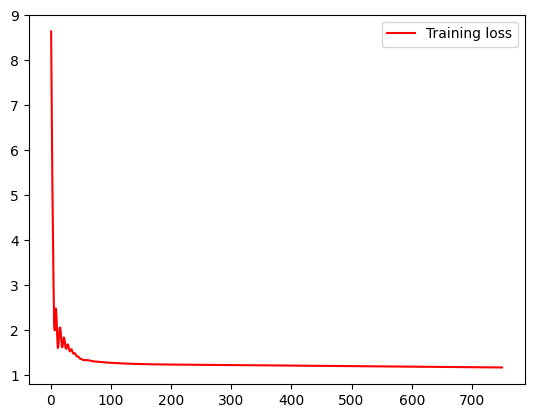

In [ ]:
plt.plot(range(1, epochs), trainLoss, 'r-', label="Training loss")
plt.plot(range(1, epochs), testLoss, 'b-', label="Testing loss")
plt.legend()
plt.show()